In [1]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz
from hrvanalysis import get_time_domain_features,get_csi_cvi_features,get_frequency_domain_features,get_geometrical_features,get_sampen,get_poincare_plot_features

# misc
import warnings

In [2]:
# training,test,devel data index extraction from partition file
partition  = pd.read_csv(f"/Thesis_data/c3_muse_stress_2022/metadata/partition.csv")
partition_train_index=partition[(partition["Partition"]=="train")]["Id"].to_numpy()
partition_devel_index=partition[(partition["Partition"]=="devel")]["Id"].to_numpy()
partition_test_index=partition[(partition["Partition"]=="test")]["Id"].to_numpy()
partition_index = partition[(partition["Partition"]=="train") | (partition["Partition"]=="devel")|(partition["Partition"]=="test")]["Id"].to_numpy()

## Plotting ECG signal

In [3]:
# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for ECG sensor
settings = {}
settings['fs'] = 500

In [27]:
df = pd.read_csv(f"/Thesis_data/c3_muse_stress_2022/feature_segments/ECG_raw/1.csv")

In [ ]:
plt.figure(figsize=(10, 4))
start = 0
stop = 2000
duration = (stop-start) / settings['fs']
plt.title("ECG signal, slice of %.1f seconds" % duration)
plt.plot(df[start:stop].timestamp, df[start:stop].ECG, color="red", linewidth=1)
# plt.plot(df1[:8].timestamp, df1[:8].ECG, color="green", linewidth=1)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)")
plt.show()

## Statistics and plots from raw ECG signal

In [26]:
import neurokit2 as nk
import matplotlib.pyplot as plt
plt.rc('font', size=8)
data = pd.read_csv(f"/Thesis_data/c3_muse_stress_2022/feature_segments/ECG_raw/1.csv")

ecg_cleaned = nk.ecg_clean(data["ECG"], sampling_rate=1000)
peaks, info = nk.ecg_peaks(data["ECG"], sampling_rate=1000, correct_artifacts=True)
hrv_indices = nk.hrv(peaks, sampling_rate=100, show=False)

In [21]:
import neurokit2 as nk
data = pd.read_csv(f"/Thesis_data/c3_muse_stress_2022/feature_segments/ECG_raw/1.csv")
peaks, info = nk.ecg_peaks(data["ECG"], sampling_rate=1000, correct_artifacts=True)
hrv = nk.hrv_time(peaks, sampling_rate=1000, show=False)
# nk.hrv(peaks, sampling_rate=1000)
# peaks
x=info['ECG_R_Peaks']
rr_intervals_list= [x[i+1]-x[i] for i in range(len(x)-1)]

In [ ]:
from hrvanalysis import plot_poincare,plot_timeseries,plot_psd,plot_distrib

plot_distrib(rr_intervals_list)

In [ ]:
from hrvanalysis import plot_psd

# nn_intervals_list contains integer values of NN-interval

plot_psd(rr_intervals_list, method="welch")


# ECG frequency,time and non-linear feature extraction

In [ ]:
from hrvanalysis import get_time_domain_features,get_frequency_domain_features
import warnings
import neurokit2 as nk

warnings.filterwarnings("ignore")

for j in partition_index:
    data_processed = pd.read_csv(f"/Thesis_data/c3_muse_stress_2022/feature_segments/ECG/{j}.csv")
    data=pd.read_csv(f"/Thesis_data/c3_muse_stress_2022/feature_segments/ECG_raw/{j}.csv")

    hrv_timedomain=pd.DataFrame()
    hrv_freqdomain=pd.DataFrame()

    length= len(data_processed)
    
    for i in range(0,len(data)-2000,500):
        peaks, info = nk.ecg_peaks(data["ECG"].values[i:i+3000], sampling_rate=1000)
        x=info['ECG_R_Peaks']
        rr_intervals_list= [x[i+1]-x[i] for i in range(len(x)-1)]
        try :
            time_domain_features = get_time_domain_features(rr_intervals_list)
            freq_domain_features = get_frequency_domain_features(rr_intervals_list)
            u=pd.DataFrame(time_domain_features, index=[i])
            v=pd.DataFrame(freq_domain_features, index=[i])

        except:
            pass
        hrv_timedomain=pd.concat([hrv_timedomain,u])
        hrv_freqdomain=pd.concat([hrv_freqdomain,v])
    
    length=(length-len(hrv_timedomain))//2
    hrv_freqdomain.fillna(method='ffill',inplace=True)
        
    for i in range(length):
        hrv_timedomain=pd.concat([hrv_timedomain.iloc[:1,:], hrv_timedomain, hrv_timedomain.iloc[-1:,:]]).reset_index()
        hrv_freqdomain=pd.concat([hrv_freqdomain.iloc[:1,:], hrv_freqdomain, hrv_freqdomain.iloc[-1:,:]]).reset_index()

    hrv_timedomain['timestamp']=data_processed['timestamp'].values
    hrv_timedomain['subject_id']=data_processed['subject_id'].values
    hrv_timedomain.drop(['index','nni_50', 'pnni_50','nni_20','pnni_20','level_0'], axis=1,inplace=True)
    hrv_freqdomain['timestamp']=data_processed['timestamp'].values
    hrv_freqdomain['subject_id']=data_processed['subject_id'].values
    hrv_freqdomain.drop(['index','level_0'], axis=1,inplace=True)
    cols = hrv_timedomain.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    hrv_timedomain = hrv_timedomain[cols] 
    
    cols_freq=hrv_freqdomain.columns.tolist()
    cols_freq = cols_freq[-2:] + cols_freq[:-2]
    hrv_freqdomain = hrv_freqdomain[cols_freq] 


    hrv_timedomain.to_csv(f"D:/Thesis_data/c3_muse_stress_2022/feature_segments/ECGtime/{j}.csv",index=False)
    hrv_freqdomain.to_csv(f"D:/Thesis_data/c3_muse_stress_2022/feature_segments/ECGfreq/{j}.csv",index=False)


In [ ]:
from hrvanalysis import get_geometrical_features,get_csi_cvi_features
import warnings
# system imports
import os
import sys
import neurokit2 as nk

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings

warnings.filterwarnings("ignore")

# training,test,devel data index extraction from partition file
partition  = pd.read_csv(f"/Thesis_data/c3_muse_stress_2022/metadata/partition.csv")
partition_train_index=partition[(partition["Partition"]=="train")]["Id"].to_numpy()
partition_devel_index=partition[(partition["Partition"]=="devel")]["Id"].to_numpy()
partition_test_index=partition[(partition["Partition"]=="test")]["Id"].to_numpy()
partition_index = partition[(partition["Partition"]=="train") | (partition["Partition"]=="devel")|(partition["Partition"]=="test")]["Id"].to_numpy()

for j in partition_index:
    data_processed = pd.read_csv(f"/Thesis_data/c3_muse_stress_2022/feature_segments/ECG/{j}.csv")
    data=pd.read_csv(f"/Thesis_data/c3_muse_stress_2022/feature_segments/ECG_raw/{j}.csv")

    hrv_geometric=pd.DataFrame()
    hrv_nonlinear1=pd.DataFrame()
    hrv_nonlinear2=pd.DataFrame()

    length= len(data_processed)
    
    for i in range(0,len(data)-2000,500):
    #     ecg_cleaned = nk.ecg_clean(data["ECG"].values[i:i+2000], sampling_rate=1000)
        peaks, info = nk.ecg_peaks(data["ECG"].values[i:i+5000], sampling_rate=1000)
        x=info['ECG_R_Peaks']
        rr_intervals_list= [x[i+1]-x[i] for i in range(len(x)-1)]
        try :
            geo_domain_features = get_geometrical_features(rr_intervals_list)
            nonlin_domain_features = get_csi_cvi_features(rr_intervals_list)
            nonlin_domain_features2= get_poincare_plot_features(rr_intervals_list)
            u=pd.DataFrame(geo_domain_features, index=[i])
            v=pd.DataFrame(nonlin_domain_features, index=[i])
            w=pd.DataFrame(nonlin_domain_features2, index=[i])

        except:
            pass
        hrv_geometric=pd.concat([hrv_geometric,u])
        hrv_nonlinear1=pd.concat([hrv_nonlinear1,v])
        hrv_nonlinear2=pd.concat([hrv_nonlinear2,w])

        
    hrv_nonlinear.replace([np.inf, -np.inf], np.nan, inplace=True)    
    hrv_nonlinear1.fillna(method='ffill',inplace=True)
    hrv_nonlinear2.fillna(method='ffill',inplace=True)

    hrv_geometric.drop(['tinn'], axis=1,inplace=True)
    
    length=(length-len(hrv_nonlinear1))//2
    
    for i in range(length):
        hrv_nonlinear1=pd.concat([hrv_nonlinear1.iloc[:1,:], hrv_nonlinear1, hrv_nonlinear1.iloc[-1:,:]]).reset_index()
        hrv_nonlinear2=pd.concat([hrv_nonlinear2.iloc[:1,:], hrv_nonlinear2, hrv_nonlinear2.iloc[-1:,:]]).reset_index()
        hrv_geometric=pd.concat([hrv_geometric.iloc[:1,:], hrv_geometric, hrv_geometric.iloc[-1:,:]]).reset_index()
    
    hrv_nonlinear1['triangular_index']=hrv_geometric['triangular_index'].values
    hrv_nonlinear1[['sd1','sd2','ratio_sd2_sd1']]=hrv_nonlinear2[['sd1','sd2','ratio_sd2_sd1']]
    hrv_nonlinear1['timestamp']=data_processed['timestamp'].values
    hrv_nonlinear1['subject_id']=data_processed['subject_id'].values
#     hrv_timedomain.drop(['index','nni_50', 'pnni_50','nni_20','pnni_20','level_0'], axis=1,inplace=True)
    
   
    hrv_nonlinear1.drop(['index','level_0'], axis=1,inplace=True)
    cols = hrv_nonlinear1.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    hrv_nonlinear1 = hrv_nonlinear1[cols]
   
    hrv_nonlinear1.to_csv(f"D:/Thesis_data/c3_muse_stress_2022/feature_segments/ECG_nonlinear/{j}.csv",index=False)


## GASF and GADF plots

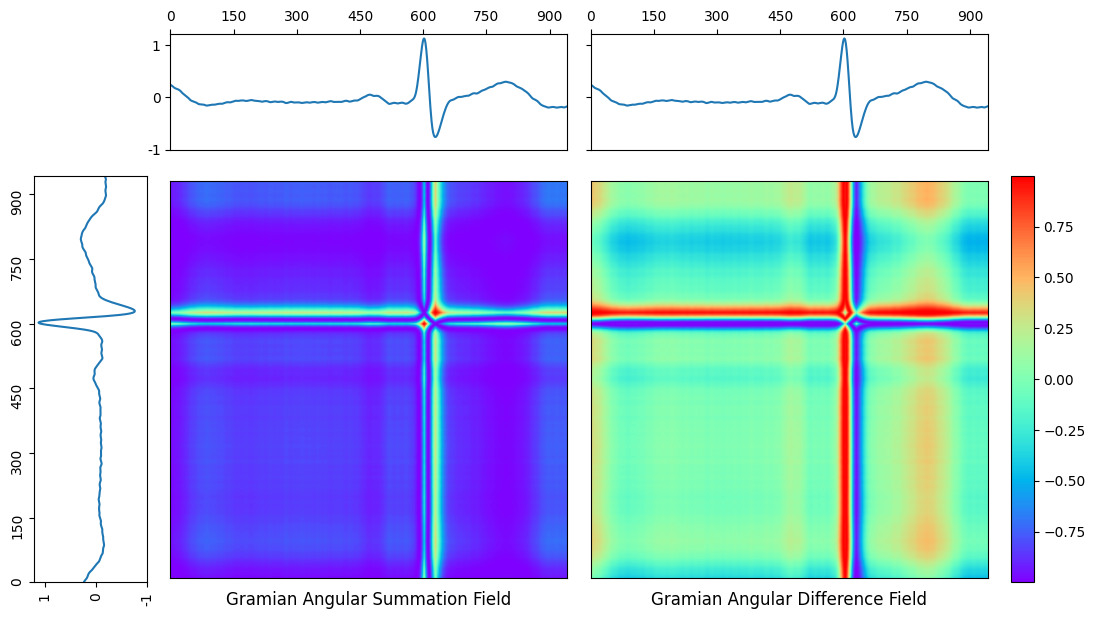

In [173]:

import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField


# # Create a toy time series using the sine function
# time_points = np.linspace(0, 4 * np.pi, 1000)
# x = np.sin(time_points)
# X = np.array([x])

data = pd.read_csv(f"/Thesis_data/c3_muse_stress_2022/feature_segments/ECG_raw/1.csv")
data=data['ECG'][:1000]

X = np.array([data])
# Compute Gramian angular fields
gasf = GramianAngularField(method='summation')
X_gasf = gasf.fit_transform(X)
gadf = GramianAngularField(method='difference')
X_gadf = gadf.fit_transform(X)

# Plot the time series and its recurrence plot
width_ratios = (2, 7, 7, 0.4)
height_ratios = (2, 7)
width = 12.5
height = width * sum(height_ratios) / sum(width_ratios)
fig = plt.figure(figsize=(width, height))
gs = fig.add_gridspec(2, 4,  width_ratios=width_ratios,
                      height_ratios=height_ratios,
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.1, hspace=0.1)

# Define the ticks and their labels for both axes
time_ticks = np.linspace(0, 4 * np.pi, 9)
time_ticklabels = [r'$0$', r'$150$',r'$300$',
                   r'450$', r'$600$', r'$750$',
                   r'$900$',  r'$1000$',]
value_ticks = [-1, 0, 1]
reversed_value_ticks = value_ticks[::-1]

# Plot the time series on the left with inverted axes
ax_left = fig.add_subplot(gs[1, 0])
ax_left.plot(data, time_points)
ax_left.set_xticks(reversed_value_ticks)
ax_left.set_xticklabels(reversed_value_ticks, rotation=90)
# ax_left.set_yticks(time_ticks)
ax_left.set_yticklabels([0,150,300,450,600,750,900,1000], rotation=90)
ax_left.set_ylim((0, 4 * np.pi))
ax_left.invert_xaxis()

# Plot the time series on the top
ax_top1 = fig.add_subplot(gs[0, 1])
ax_top2 = fig.add_subplot(gs[0, 2])
for ax in (ax_top1, ax_top2):
    ax.plot(time_points, data)
#     ax.set_xticks(time_ticks)
    ax.set_xticklabels([0,150,300,450,600,750,900,1000])
    ax.set_yticks(value_ticks)
    ax.xaxis.tick_top()
    ax.set_xlim((0, 4 * np.pi))
ax_top1.set_yticklabels(value_ticks)
ax_top2.set_yticklabels([])

# Plot the Gramian angular fields on the bottom right
ax_gasf = fig.add_subplot(gs[1, 1])
ax_gasf.imshow(X_gasf[0], cmap='rainbow', origin='lower',
               extent=[0, 4 * np.pi, 0, 4 * np.pi])
ax_gasf.set_xticks([])
ax_gasf.set_yticks([])
ax_gasf.set_title('Gramian Angular Summation Field', y=-0.09)

ax_gadf = fig.add_subplot(gs[1, 2])
im = ax_gadf.imshow(X_gadf[0], cmap='rainbow', origin='lower',
                    extent=[0, 4 * np.pi, 0, 4 * np.pi])
ax_gadf.set_xticks([])
ax_gadf.set_yticks([])
ax_gadf.set_title('Gramian Angular Difference Field', y=-0.09)

# Add colorbar
ax_cbar = fig.add_subplot(gs[1, 3])
fig.colorbar(im, cax=ax_cbar)

plt.show()

## Converting the saved GASF and GADF features in numpy into individual participants csv files from 

In [ ]:
import pandas as pd
import glob
import re


for i in partition_index:
    path = f'D:/Thesis_data/models/{i}/*.out'

    file_paths = glob.glob(path)
    file_paths = [file_path.replace('\\', '/') for file_path in file_paths]
    data=pd.read_csv(f"/Thesis_data/c3_muse_stress_2022/feature_segments/ECG/{i}.csv")
    def sort_by_numeric_file_name(file_path):
        file_name = file_path.split('/')[-1].split('.')[0]
        return int(file_name)

    file_paths = sorted(file_paths, key=sort_by_numeric_file_name)

    df = pd.DataFrame()

    for file_path in file_paths:
        file_name = file_path.split('/')[-1].split('.')[0]
        series = pd.read_csv(file_path, header=None, squeeze=True)
        df[file_name] = series
        
        
    df = df.T
    df['timestamp']=data['timestamp'].values
    df['subject_id']=data['subject_id'].values
    cols = df.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df = df[cols]
    print(df)
    df.to_csv(f'D:/Thesis_data/c3_muse_stress_2022/feature_segments/gasf/{i}.csv', index=False)

     